# Encoder Decoder model with attention

In [1]:
!pip install torcheval

# Import libraries pythoch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import io
from torcheval.metrics.functional import word_error_rate


os.environ['TORCH_USE_CUDA_DSA'] = '1'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# Set seed
SEED = 999999
BATCH_SIZE = 1 # Batch size

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

  Obtaining dependency information for torcheval from https://files.pythonhosted.org/packages/e4/de/e7abc784b00de9d05999657d29187f1f7a3406ed10ecaf164de06482608f/torcheval-0.0.7-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 1.7 MB/s eta 0:00:00 0:00:010m


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


cuda


## Import Data

In [2]:


class CustomDataset(Dataset):
    def __init__(self, data_dir, label_file):
        self.data_dir = data_dir
        self.sample_paths = []
        self.labels = []
        
        # Read the label file
        with open(label_file, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        
        # Iterate over the sentence folders to get sample paths and labels
        for sentence_folder in sorted(os.listdir(data_dir)):
            sentence_path = os.path.join(data_dir, sentence_folder)
            if not os.path.isdir(sentence_path):
                continue
            
            for sample_folder in sorted(os.listdir(sentence_path)):
                sample_path = os.path.join(sentence_path, sample_folder)
                if not os.path.isdir(sample_path):
                    continue
                
                self.sample_paths.append(sample_path)
                
                # Extract the label from the corresponding line in the label file
                sentence_index = int(sentence_folder) - 1
                label = lines[sentence_index].strip()
                self.labels.append(label)
    
    def __len__(self):
        return len(self.sample_paths)
    
    def __getitem__(self, index):
        sample_path = self.sample_paths[index]
        label = self.labels[index]

        # Load all frames of the sample and convert them to tensors
        frames = []
        for frame_file in sorted(os.listdir(sample_path)):
            if frame_file.endswith('.jpg'):
                frame_path = os.path.join(sample_path, frame_file)
                frame = Image.open(frame_path)
                frame = transforms.ToTensor()(frame)
                frames.append(frame)
        signer = sample_path.split('/')[-1][:2]
#         signer = sample_path.split('\\')[-1][:2]
        return frames, label, signer

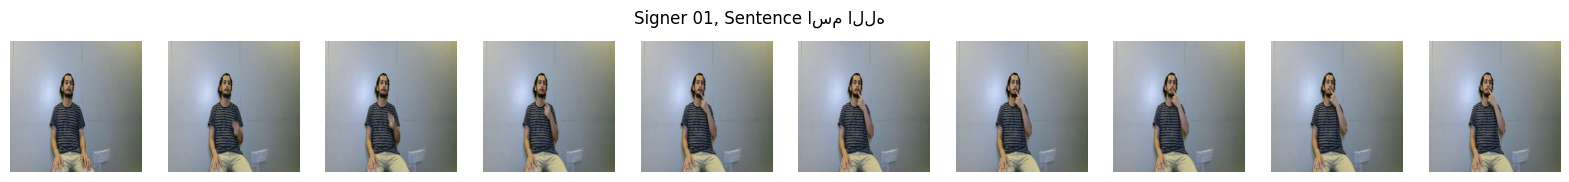

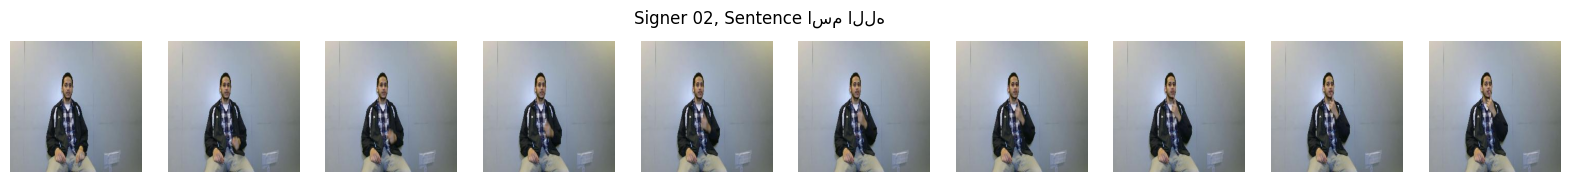

In [3]:
train = "/kaggle/input/assignment3/Assignment03/train"
test = "/kaggle/input/assignment3/Assignment03/test"
ground_truth = "/kaggle/input/assignment3/Assignment03/groundTruth.txt"
# train = "Assignment03/train"
# test = "Assignment03/test"
# ground_truth = "Assignment03/groundTruth.txt"

# data is in the form of (frames, label) where frames is a list of tensors
train_data = CustomDataset(train, ground_truth)
test_data = CustomDataset(test, ground_truth)


# show sample images of each signer in the training set
for signer in ['01', '02']:
    fig, axs = plt.subplots(1, 10, figsize=(20, 2))
    fig.suptitle('Signer {}, Sentence {}'.format(signer, train_data[0][1]))
    for i in range(len(train_data)):
        frames, label, signer_ = train_data[i]
        if signer_ == signer:
            for j in range(10):
                axs[j].imshow(frames[j].permute(1, 2, 0))
                axs[j].axis('off')
            break
plt.show()

In [4]:
# from gensim.models import fasttext
# from gensim.test.utils import datapath

# word_vectors = fasttext.load_facebook_vectors(datapath("C:/Users/xmxm7/Desktop/HW3/cc.ar.300.bin"))

In [5]:
# load the weights matrix
weights_matrix = torch.load('/kaggle/input/weight-matrix/weights_matrix.pt')

# weights_matrix = torch.load('weights_matrix.pt')
weights_matrix

tensor([[ 0.1161,  0.0854,  0.0775,  ...,  0.0719, -0.0970,  0.0040],
        [ 0.0479,  0.0322,  0.0060,  ...,  0.0287,  0.0207, -0.0556],
        [-0.0789, -0.0330,  0.0359,  ...,  0.0250, -0.0825, -0.0008],
        ...,
        [-0.0148, -0.0584,  0.0724,  ..., -0.0016,  0.0184,  0.0247],
        [-0.0108, -0.0191,  0.0106,  ...,  0.0398,  0.0088, -0.0168],
        [-0.0147,  0.0025, -0.0358,  ...,  0.0047,  0.0366,  0.0213]],
       device='cuda:0', dtype=torch.float64)

In [6]:
# Create a vocabulary of words
SOS_token = 0  # Define the SOS token as 0
EOS_token = 1  # Define the EOS token as 1
UNK_token = 2  # Define the UNK token as 2

vocab = []
vocab.append("SOS")
vocab.append("EOS")
vocab.append("UNK")
for sentence in train_data.labels:
    for word in sentence.split():
        if word not in vocab:
            vocab.append(word)

# Create a dictionary of words and their corresponding index
word_to_ix = {}
for word in vocab:
        word_to_ix[word] = vocab.index(word)
print(word_to_ix)

ix_to_word = {v: k for k, v in word_to_ix.items()}
print(ix_to_word)

# Create a dictionary of labels and their corresponding index
label_to_ix = {label: i for i, label in enumerate(set(train_data.labels))}
print(label_to_ix)

# Create a matrix of word vectors
matrix_len = len(vocab)
# weights_matrix = np.zeros((matrix_len, 300))
words_found = 0
for i, word in enumerate(vocab):
    try: 
        print(word, i)
        # weights_matrix[i] = word_vectors[word]
        words_found += 1
    except KeyError:
        # weights_matrix[i] = np.random.normal(scale=0.6, size=(300, ))
        pass

weights_matrix = weights_matrix.to(device)
print("Words found in pre-trained vectors: {}/{}".format(words_found, matrix_len))
print(weights_matrix.shape)

# # save the weights matrix
# torch.save(weights_matrix, 'weights_matrix.pt')

{'SOS': 0, 'EOS': 1, 'UNK': 2, 'اسم': 3, 'الله': 4, 'الحمد': 5, 'جميع': 6, 'الصم': 7, 'العرب': 8, 'السامع': 9, 'السلام': 10, 'عليكم': 11, 'رحمة': 12, 'بركة': 13, 'اليوم': 14, 'اقدم': 15, 'انتم': 16, 'برنامج': 17, 'اخر': 18, 'موضوع': 19, 'دراسة': 20, 'لغة': 21, 'الاشارة': 22, 'العربية': 23, 'كلمات': 24, 'متفرقة': 25, 'في': 26, 'الدين': 27, 'ايضا': 28, 'عادية': 29, 'لا': 30, 'شرك': 31, 'اكبر': 32}
{0: 'SOS', 1: 'EOS', 2: 'UNK', 3: 'اسم', 4: 'الله', 5: 'الحمد', 6: 'جميع', 7: 'الصم', 8: 'العرب', 9: 'السامع', 10: 'السلام', 11: 'عليكم', 12: 'رحمة', 13: 'بركة', 14: 'اليوم', 15: 'اقدم', 16: 'انتم', 17: 'برنامج', 18: 'اخر', 19: 'موضوع', 20: 'دراسة', 21: 'لغة', 22: 'الاشارة', 23: 'العربية', 24: 'كلمات', 25: 'متفرقة', 26: 'في', 27: 'الدين', 28: 'ايضا', 29: 'عادية', 30: 'لا', 31: 'شرك', 32: 'اكبر'}
{'لا شرك الله': 0, 'السلام عليكم رحمة الله بركة': 1, 'الحمد الله': 2, 'اليوم اقدم انتم برنامج اخر': 3, 'كلمات اليوم متفرقة في الدين': 4, 'جميع الصم العرب  السامع': 5, 'ايضا كلمات عادية': 6, 'اسم الله': 

In [7]:
import torchvision.models as models
class CustomMobileNetV2(torch.nn.Module):
    
    def __init__(self):
        super(CustomMobileNetV2,self).__init__()
        mobilenet_v2 = models.mobilenet_v2(pretrained=True)
        layers = list(mobilenet_v2.children())[:-1]  # Remove the classification layer
        self.mobilenet_v2 = torch.nn.Sequential(*layers)

    def forward(self, x): 
        y_pred = self.mobilenet_v2(x)
        return y_pred 

# Load the pretrained MobileNetV2 model
mobilenet = CustomMobileNetV2()
mobilenet.to(device)
mobilenet.eval()

torch.save(mobilenet, 'mobilenet.pt')

# disable gradient computation
for param in mobilenet.parameters():
    param.requires_grad = False


def extract_features(sample):
    frames = sample[0]
    frames = [mobilenet(frame.unsqueeze(0).to(device)) for frame in frames]
    return frames

def embed_label(sample):

    label = sample[1]
    label = label.split()
    # print(label)
    tokenized_sequences = [[word_to_ix[word] if word in word_to_ix else UNK_token for word in label]]
    tokenized_sequences = torch.tensor(tokenized_sequences, dtype=torch.long)
    
    # Add SOS and EOS tokens to the sequences
    tokenized_sequences_with_sos_eos = [torch.cat((torch.tensor([SOS_token]), seq, torch.tensor([EOS_token]))) for seq in tokenized_sequences]
    # to tensor
    tokenized_sequences_with_sos_eos = torch.stack(tokenized_sequences_with_sos_eos)

    # Pad sequences to the maximum length
    max_length = 7  # Specify the maximum length for padding, including SOS and EOS
    padded_sequences = torch.nn.functional.pad(tokenized_sequences_with_sos_eos, (0, max_length - tokenized_sequences_with_sos_eos.size(1)), value=EOS_token)[0]

    # print(padded_sequences)
    # print()
    # Get the weights for each token
    weights = weights_matrix[padded_sequences]

    return weights.squeeze()


class CustomDataLoader(DataLoader):
    def __init__(self, dataset, batch_size, shuffle=False, num_workers=0):
        super().__init__(dataset=dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=self.collate_fn)
    
    def collate_fn(self, batch):
       
        all_frames = []
        for sample in batch:
            frames = extract_features(sample)
            all_frames.append(torch.stack(frames).to(device))
        all_frames = torch.stack(all_frames).squeeze().unsqueeze(0)

        # Convert the list of labels to a tensor and move it to the GPU
        labels = [embed_label(sample).to(device) for sample in batch]
        labels = torch.stack(labels).squeeze().unsqueeze(0)

        # Get label words indices and move the tensor to the GPU
        label_idxs = []
        for sample in batch:
            label = sample[1]
            label = label.split()
            label_idxs.append([word_to_ix[word] if word in word_to_ix else UNK_token for word in label])
        label_idxs = torch.tensor(label_idxs, dtype=torch.long).to(device)
        label_idxs = torch.nn.functional.pad(label_idxs, (0, 7 - label_idxs.size(1)), value=EOS_token)[0]
        label_idxs = label_idxs.squeeze().unsqueeze(0)

        return all_frames, labels, label_idxs

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 110MB/s] 


In [8]:
import gc
gc.collect()
# Create the training and testing data loaders
train_loader = CustomDataLoader(train_data, batch_size=1, shuffle=True, num_workers=0)
test_loader = CustomDataLoader(test_data, batch_size=1, shuffle=False, num_workers=0)

# get the training indices that will be used for validation
indices = np.arange(len(train_data))
np.random.shuffle(indices)
split = int(0.2 * len(train_data))
train_idx, val_idx = indices[split:], indices[:split]

# define subsets for obtaining training and validation batches
train_subset = torch.utils.data.Subset(train_data, train_idx)
val_subset = torch.utils.data.Subset(train_data, val_idx)


# define dataloaders
train_loader = CustomDataLoader(train_subset, batch_size=1, shuffle=True)
val_loader = CustomDataLoader(val_subset, batch_size=1, shuffle=False)
test_loader = CustomDataLoader(test_data, batch_size=1, shuffle=False)

# print the number of samples in each set
print('Number of Train samples:', len(indices))
print('Number of training samples:', len(train_subset))
print('Number of validation samples:', len(val_subset))
print('Number of test samples:', len(test_data))


Number of Train samples: 534
Number of training samples: 428
Number of validation samples: 106
Number of test samples: 66


## Attention

In [9]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super().__init__()
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        self.attention_dim = attention_dim
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.v = nn.Linear(attention_dim, 1)

    def forward(self, encoder_out, decoder_hidden):
        # print("att enc out, dec hdn", encoder_out.shape, decoder_hidden.shape)
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden)
        # print("att1, att2", att1.shape, att2.shape)
        att = self.v(torch.tanh(att1 + att2.unsqueeze(1))).squeeze(2)
        # print("att", att.shape)
        alpha = F.softmax(att, dim=1)
        # print("alpha", alpha.shape)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
        # print("att wgt enc", attention_weighted_encoding.shape)
        return attention_weighted_encoding.unsqueeze(0)
    
    
    
class EncoderAtt(nn.Module):
    def __init__(self, hidden_dim, n_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.rnn = nn.LSTM(1280 * 8*8, hidden_dim, n_layers, dropout=0.3)
        
    def forward(self, src):
        x = src.view(src.shape[0], 1, -1)
        x = x.to(self.device)
        a, (hidden, _) = self.rnn(x)
        return a
    
class DecoderAtt(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_len, n_layers=2, attention_dim=256):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_len = vocab_len
        self.n_layers = n_layers
        self.attention_dim = attention_dim
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.rnn = nn.LSTM(embedding_dim + hidden_dim, hidden_dim, n_layers, dropout=0.3)
        self.attention = Attention(hidden_dim, hidden_dim, attention_dim)
        self.fc_out = nn.Linear(hidden_dim, vocab_len)

        
    def forward(self, features, caption):
        features = features.squeeze().unsqueeze(0)
        # print("fwd fet, cap", features.shape, caption.shape)

        embeddings = torch.cat((features, caption), dim=1)
        embeddings = embeddings.float()

        attention_weighted_encoding = self.attention(features, embeddings[:, -2, :]).squeeze(0)
        # print("fwd att wgt enc", attention_weighted_encoding.shape)
        embeddings = torch.cat((embeddings[:, -2, :], attention_weighted_encoding), dim=1)
        # print("fwd embd", embeddings.shape)
        lstm_out, _ = self.rnn(embeddings)
        # print("fwd lstm out", lstm_out.shape)
        output = self.fc_out(lstm_out)
        # print("fwd out", output.shape)
        return output, lstm_out[-1][-1]
    
    
    
    
import random
class Seq2SeqAtt(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.encoder = encoder
        self.decoder = decoder
        self.teacher_forcing_ratio = 0.5
        
    def forward(self, src, trg=None): 
        vocab_len = self.decoder.vocab_len
        features = self.encoder(src)

        input = torch.tensor(weights_matrix[SOS_token]).to(self.device).unsqueeze(0).unsqueeze(0)
        output, _ = self.decoder(features, input)
#         print("seq out", output.shape)
        outputs = torch.zeros(7-1, vocab_len).to(self.device)
        for t in range(1, 7):
            next_word = torch.argmax(output, dim=1)
            next_word = torch.tensor(weights_matrix[next_word]).to(self.device).unsqueeze(0)
            teacher_force = random.random() < self.teacher_forcing_ratio
            if trg is not None and teacher_force:
                # print("teacher force")
                next_word = trg[t-1,:].unsqueeze(0).unsqueeze(0)
            if t == 6:
                next_word = torch.tensor(weights_matrix[EOS_token]).to(self.device).unsqueeze(0).unsqueeze(0)
            input = torch.cat((input, next_word), dim=1)
            output, _ = self.decoder(features, input) # Autoregressive Decoding
            # print("seq out", output.shape)
            outputs[t-1] = output
        return outputs
    
    
    

In [10]:
def train_and_evaluate2(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, patience, diff, fix_train=None):
    early_stop = EarlyStop(patience=patience, diff=diff)
    losses = []
    wers = []
    for epoch in range(1, num_epochs + 1):
        gc.collect()
        model.train()
        train_loss = 0
        all_predictions_train = []
        all_targets_train = []
        for batch_idx, (src, trg, idxs) in enumerate(train_loader):
            if fix_train is not None:
                src, trg, idxs = fix_train
            src = src.squeeze(0).to(device)
            trg = trg.squeeze(0).to(device) 
            idxs = idxs.squeeze(0)[:-1].to(device)
            optimizer.zero_grad()
            output = model(src, trg)
#             print(idxs.min(), idxs.max(), output.shape)
            loss = criterion(output, idxs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            targets = idxs.squeeze() 
            predictions = torch.argmax(output, dim=1) # get the index of the max log-probability
            predection_words = [vocab[prediction] for prediction in predictions] # get the word from the vocab
            target_words = [vocab[target] for target in targets.tolist()] # get the word from the vocab
            if fix_train is not None:
                print("train batchIdx: {}, prediction: {}, target: {}".format(batch_idx, " ".join(predection_words), " ".join(target_words)))
            all_predictions_train.append(" ".join(predection_words)) # append the predicted word
            all_targets_train.append(" ".join(target_words)) # append the target word
            
        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0
        all_predictions_val = []
        all_targets_val = []
        with torch.no_grad():
            for batch_idx, (src, trg, idxs) in enumerate(val_loader):
                src = src.squeeze(0)
                trg = trg.squeeze(0)
                idxs = idxs.squeeze(0)[:-1]
                output = model(src)
                loss = criterion(output, idxs)
                val_loss += loss.item()

                targets = idxs.squeeze() 
                predictions = torch.argmax(output, dim=1) # get the index of the max log-probability
                predection_words = [vocab[prediction] for prediction in predictions] # get the word from the vocab
                target_words = [vocab[target] for target in targets.tolist()] # get the word from the vocab
                if fix_train is not None:
                    print("\t\tval batchIdx: {}, prediction: {}, target: {}".format(batch_idx, " ".join(predection_words), " ".join(target_words)))
                all_predictions_val.append(" ".join(predection_words)) # append the predicted word
                all_targets_val.append(" ".join(target_words)) # append the target word
                
        val_loss /= len(val_loader)

        wer_train = word_error_rate(all_predictions_train, all_targets_train)
        wer_val = word_error_rate(all_predictions_val, all_targets_val)
        losses.append({'train_loss': train_loss, 'val_loss': val_loss})
        wers.append({'train_wer': wer_train, 'val_wer': wer_val})
        print("Epoch {}/{} \tTrain Loss: {:.6f} \tTrain WER: {:.6f} \tValidation Loss: {:.6f} \tValidation WER: {:.6f}".format(epoch, num_epochs, train_loss, wer_train, val_loss, wer_val))

        if early_stop.early_stop(val_loss):
            print("Early stopping")
            break

    return losses, wers

In [11]:
class EarlyStop:
    def __init__(self, patience=7, diff=0):
        self.patience = patience
        self.diff = diff
        self.epoch_period = 0
        self.min_val_loss = float('inf')

    def early_stop(self, val_loss):
        if val_loss < self.min_val_loss:
            self.min_val_loss = val_loss
            self.epoch_period = 0

        elif val_loss > (self.min_val_loss + self.diff):
            self.epoch_period += 1
            if self.epoch_period >= self.patience:
                return True
        
        return False

In [12]:
import matplotlib.pyplot as plt
def plot_loss_accuracy(losses,wers):
    val_acc = [i['val_wer'] for i in wers]
    train_acc = [i['train_wer'] for i in wers]
    val_loss = [i['val_loss'] for i in losses]
    train_loss = [i['train_loss'] for i in losses]

    plt.figure(figsize=(10,10))
    plt.plot(val_loss,label = 'validation loss')
    plt.plot(train_loss,label = 'training loss')
    plt.title("loss vs epoch")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10,10))
    plt.plot(val_acc,label = 'validation WER')
    plt.plot(train_acc,label = 'training WER')
    plt.title("WER vs epoch")
    plt.xlabel('epoch')
    plt.ylabel('WER')
    plt.legend()
    plt.show()

Epoch 1/100 	Train Loss: 2.503631 	Train WER: 0.598910 	Validation Loss: 2.429785 	Validation WER: 0.581761
Epoch 2/100 	Train Loss: 2.167291 	Train WER: 0.580607 	Validation Loss: 2.213575 	Validation WER: 0.581761
Epoch 3/100 	Train Loss: 1.898528 	Train WER: 0.537773 	Validation Loss: 2.209808 	Validation WER: 0.572327
Epoch 4/100 	Train Loss: 1.793071 	Train WER: 0.500779 	Validation Loss: 2.279110 	Validation WER: 0.572327
Epoch 5/100 	Train Loss: 1.711977 	Train WER: 0.487150 	Validation Loss: 2.298563 	Validation WER: 0.606918
Epoch 6/100 	Train Loss: 1.689973 	Train WER: 0.475467 	Validation Loss: 2.243808 	Validation WER: 0.581761
Epoch 7/100 	Train Loss: 1.654541 	Train WER: 0.465343 	Validation Loss: 2.237763 	Validation WER: 0.581761
Epoch 8/100 	Train Loss: 1.627459 	Train WER: 0.460280 	Validation Loss: 2.314677 	Validation WER: 0.572327
Epoch 9/100 	Train Loss: 1.622612 	Train WER: 0.464564 	Validation Loss: 2.204595 	Validation WER: 0.581761
Epoch 10/100 	Train Loss: 1.

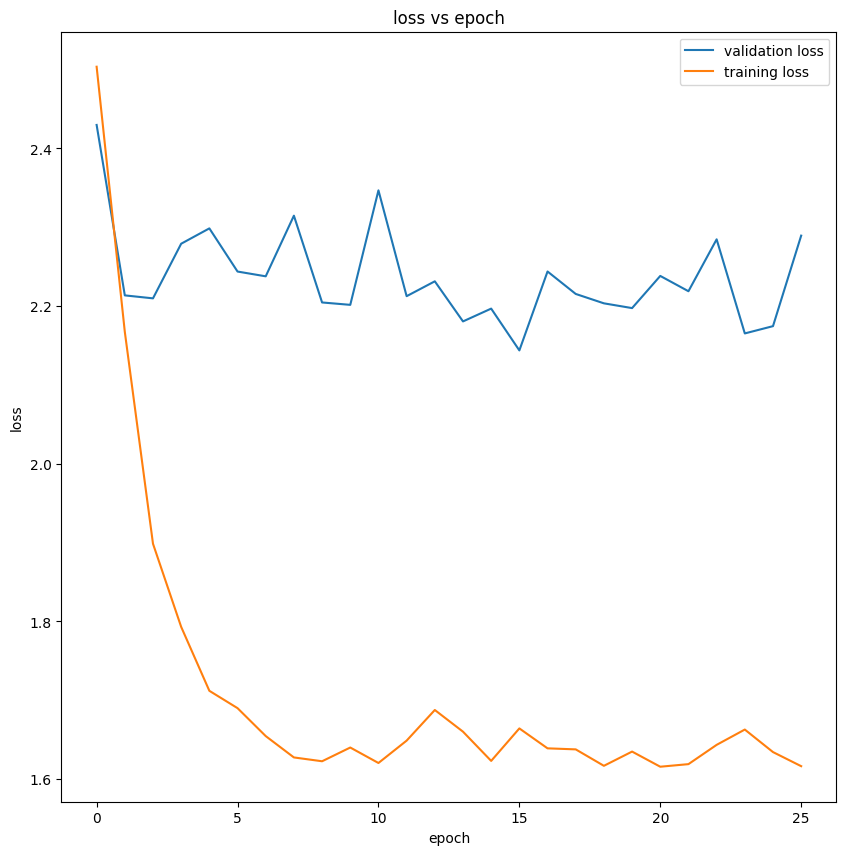

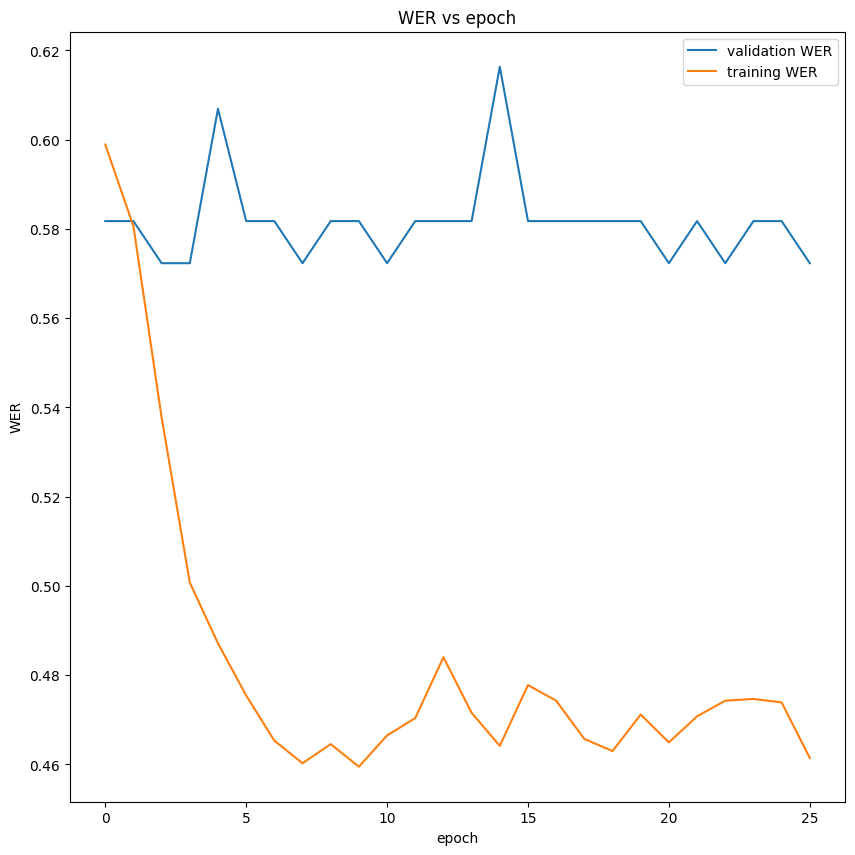

In [13]:
embedding_dim = 300
vocab_len = len(vocab)
# print(len(vocab))
hidden_dim = 300
n_layers = 3
ATTENTION_SIZE = 256

encoderAtt = EncoderAtt(hidden_dim, n_layers)
decoderAtt = DecoderAtt(embedding_dim, hidden_dim, vocab_len, n_layers, ATTENTION_SIZE)
seq2seqAtt = Seq2SeqAtt(encoderAtt, decoderAtt)

# Define your optimizer and criterion
optimizer = torch.optim.Adam(seq2seqAtt.parameters(), lr=1e-3, amsgrad=True)
criterion = nn.CrossEntropyLoss()



# # Define your device (CPU or GPU)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Train the model
encoderAtt.to(device)
decoderAtt.to(device)
seq2seqAtt.to(device)

# fix_train = next(iter(train_loader))

history = train_and_evaluate2(seq2seqAtt, train_loader, val_loader, criterion, optimizer, device, num_epochs=100,patience=10,diff=0.01)
plot_loss_accuracy(history[0],history[1])

# save the model
torch.save(seq2seqAtt, 'seq2seqAtt.pt')

In [14]:
# load the model
# seq2seqAtt = torch.load('/kaggle/working/seq2seqAtt.pt').to(device)

In [15]:
def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    all_predictions_test = []
    all_targets_test = []
    with torch.no_grad():
        for batch_idx, (src, trg, idxs) in enumerate(test_loader):
            src = src.squeeze(0).to(device)
            trg = trg.squeeze(0).to(device)
            idxs = (idxs.squeeze(0).to(device))[:-1]
            output = model(src)
            loss = criterion(output, idxs)
            test_loss += loss.item()

            targets = idxs.squeeze() 
            predictions = torch.argmax(output, dim=1) # get the index of the max log-probability
            predection_words = [vocab[prediction] for prediction in predictions] # get the word from the vocab
            target_words = [vocab[target] for target in targets.tolist()] # get the word from the vocab
            # print("val batchIdx: {}, prediction: {}, target: {}".format(batch_idx, " ".join(predection_words), " ".join(target_words)))
            all_predictions_test.append(" ".join(predection_words)) # append the predicted word
            all_targets_test.append(" ".join(target_words)) # append the target word
            
    test_loss /= len(test_loader)

    wer_test = word_error_rate(all_predictions_test, all_targets_test)
    print("Test Loss: {:.6f} \tTest WER: {:.6f}".format(test_loss, wer_test))


In [16]:
# test the model
test(seq2seqAtt, test_loader, criterion, device)



# load the model
# seq2seqAtt = torch.load('seq2seqAtt.pt')

Test Loss: 2.351676 	Test WER: 0.606061
